In [1]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from utils_segmentation import p3

np.random.seed(42)
import pickle
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [3]:
daily_flux_cook=pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023_batches_processed.csv')
daily_flux_cprl=pd.read_csv('E:/usda/work/CookIRCamET/Working/cprlhy2023_batches_processed.csv')

In [4]:
daily_flux = pd.concat([daily_flux_cook,daily_flux_cprl])

In [11]:
n_feats = len(inputs)
period_length = 1

In [12]:
batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
n_batches = batched_flux.shape[0]
n_train = int(0.9*n_batches)
n_test = n_batches-n_train
batches = np.arange(n_batches)
np.random.shuffle(batches)
train = batches[0:n_train]
test = batches[n_train:]
batches_train_et,batches_train_feats = np.sum(batched_et[train,:],axis=1),batched_flux[train,0:period_length*n_feats] 
batches_test_et,batches_test_feats =  np.sum(batched_et[test,:],axis=1),batched_flux[test,0:period_length*n_feats] 
batches_train_et.shape

(7452,)

In [13]:
#Pipeline
#initial scaling
scaler = StandardScaler()
clf = MLPRegressor(max_iter=10000)
#tune hyperparameters
layers = []

for layer1 in [1,3,7,21]:
    for layer2 in [1,3,6,18]:
        layer = (n_feats*period_length//layer1,int((n_feats*period_length//(layer2*layer1))**(2/3)),int((n_feats*period_length//(layer2*layer1))**(1/3)),period_length//layer2)
        layers.append(layer)

parameters = {'clf__hidden_layer_sizes':layers,'clf__activation':['tanh','relu','logistic','linear']}
pipeline = Pipeline(steps=[("scaler", scaler), ("clf", clf)])#

search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=3)

search.fit(batches_train_feats, batches_train_et)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
filename = os.path.join(p3,'et_mlp_pipeline_'+str(period_length)+'_final.pk.sav')
with open(filename, 'wb') as f:  # Python 3: open(..., 'wb'
    pickle.dump(search.best_estimator_, f)

pred = search.predict(batches_test_feats)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameter (CV score=0.757):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (21, 7, 2, 1)}


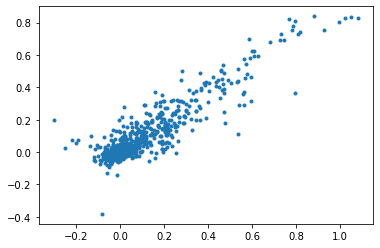

In [14]:
plt.plot(batches_test_et,pred,'.')

In [15]:
mlp = search.best_estimator_['clf']

In [16]:
n_param = 0
for i in range(4):
    n_param+=mlp.coefs_[i].shape[0]*mlp.coefs_[i].shape[0]
n_param

935